In [48]:
# --- Project Setup ---
from setup_notebook import setup_project_root
setup_project_root()

# --- Imports ---
from src.project_config import AM_PATH, ESM_PATH, PROTEIN_IDS_CSV, get_paths_protein
from scipy import stats
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
import random
import os
import numpy as np
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import fdrcorrection

### Goal of This Code
- to run Signed Wilcoxon Rank Test (non-parametric) between variants of the two models per 
residue to find minimal significant threshold for an algorithm, that identifies
clusters in difference rank scores
  
What we need:
- rank score CSV files of ESM1b and AlphaMissense
- random sample of how many proteins we take into this test

From 20300 proteins x 472 Residues (average per protein) 
- it will be far enough to take sample of 1000 proteins and 200 residues = 200.000
- statistically needed only about 10.000 residues
- since proteins have different lengths we will always only take certain percentage of residues per protein and compute it by using the total of 200.000 residues to be analyzed
- 

In [58]:
# --- Load Data ---
paths = get_paths_protein("P05067")
am = pd.read_csv(paths["am_path"], index_col=0)
esm = pd.read_csv(paths["esm_path"], index_col=0)


# Access the first column of the dataframes and remove NaN values
alpha_values = am.iloc[:, 3].dropna()
esm_values = esm.iloc[:, 3].dropna()

#print("Alpha Values:", alpha_values)
#print("ESM Values:", esm_values)

stats.wilcoxon(alpha_values, esm_values)


WilcoxonResult(statistic=np.float64(36.0), pvalue=np.float64(0.015972137451171875))

In [5]:
average_protein_length = 555
count_residues = 0 

ids = pd.read_csv(PROTEIN_IDS_CSV, header=0)
random.seed(42)
random_proteins = random.sample(range(len(ids)), 1000)




# Initialize array of tuples for storing rank test results and mean differences
rank_test_results = []

for protein in tqdm(random_proteins, desc="Processing Proteins"):

    # Get paths for the current protein
    am = get_paths_protein(ids.iloc[protein, 0])["am_path"]
    esm = get_paths_protein(ids.iloc[protein, 0])["esm_path"]

    # Load the data
    am_data = pd.read_csv(am, index_col=0)
    esm_data = pd.read_csv(esm, index_col=0)

    # Check if both proteins have same length
    if am_data.shape[1] != esm_data.shape[1]:
        print(f"Skipping {protein} due to different number of residues in AM and ESM data.")
        continue  # Skip the current protein and move to the next one in the outer loop

    # Loop over random residue positions in that protein (columns)
    percentage = am_data.shape[1] / average_protein_length
    random_residues = random.sample(range(am_data.shape[1]), round(200*percentage))

    for residue in random_residues:
        try:
            # Get the values for the current residue
            am_value = am_data.iloc[:, residue].dropna()
            esm_value = esm_data.iloc[:, residue].dropna()

            # compute p-value and mean difference
            statistics, pvalue = stats.wilcoxon(am_value, esm_value)
            mean_difference = esm_value.mean() - am_value.mean()

            # Append the results to the list as tuple
            rank_test_results.append((pvalue, mean_difference))
            count_residues += 1
        except Exception as e:
            print(f"Error processing residue {residue} for protein {ids.iloc[protein, 0]}: {e}")
            continue

clear_output(wait=True)
print(f"Total residues processed: {count_residues}")
print(f"Total tuples: {len(rank_test_results)}")

Processing Proteins:   0%|          | 0/1000 [00:00<?, ?it/s]

Skipping 3648 due to different number of residues in AM and ESM data.
Skipping 4572 due to different number of residues in AM and ESM data.
Skipping 19349 due to different number of residues in AM and ESM data.
Skipping 7164 due to different number of residues in AM and ESM data.
Error processing residue 407 for protein Q12840: Array shapes are incompatible for broadcasting.
Skipping 18585 due to different number of residues in AM and ESM data.
Skipping 8609 due to different number of residues in AM and ESM data.
Skipping 2978 due to different number of residues in AM and ESM data.
Skipping 8630 due to different number of residues in AM and ESM data.
Skipping 16403 due to different number of residues in AM and ESM data.
Error processing residue 1269 for protein Q02952: Array shapes are incompatible for broadcasting.
Skipping 2806 due to different number of residues in AM and ESM data.
Skipping 19277 due to different number of residues in AM and ESM data.
Skipping 15906 due to different

In [45]:
corrected_pvalues = fdrcorrection([x[0] for x in rank_test_results])[1]



# Combine corrected p-values with the second value from rank_test_results
corrected_pvalues = [
    (corrected_pvalue, rank_test_results[i][1]) 
    for i, corrected_pvalue in enumerate(corrected_pvalues)
]

# Example: Accessing the updated corrected_pvalues


print(corrected_pvalues[1])
print(rank_test_results[1])


(np.float64(0.8525328304461361), np.float64(-0.0016500000000000403))
(np.float64(0.8287849426269531), np.float64(-0.0016500000000000403))


In [46]:
# 198236 wilcoxon test results
print(rank_test_results[2][0])
significant_results = []
non_significant_results = []
signif_results_corrected = []
non_signif_results_corrected = []

for i in tqdm(range(len(rank_test_results)), desc="Filtering Significant Results"):
    if rank_test_results[i][0] < 0.05:
        significant_results.append(rank_test_results[i][1])
    else:
        non_significant_results.append(rank_test_results[i][1])

    if corrected_pvalues[i][0] < 0.05:
        signif_results_corrected.append(corrected_pvalues[i][1])
    else:
        non_signif_results_corrected.append(corrected_pvalues[i][1])


0.000209808349609375


Filtering Significant Results:   0%|          | 0/198236 [00:00<?, ?it/s]

In [8]:
print(significant_results[1])  # Print first 10 significant results

-0.1392457894736845


Significant results: 146644
Non-significant results: 51592


(array([1.888e+03, 1.929e+03, 1.926e+03, 1.903e+03, 1.919e+03, 1.891e+03,
        1.829e+03, 1.923e+03, 1.862e+03, 1.954e+03, 1.773e+03, 1.804e+03,
        1.757e+03, 1.782e+03, 1.665e+03, 1.653e+03, 1.602e+03, 1.529e+03,
        1.503e+03, 1.354e+03, 1.312e+03, 1.278e+03, 1.200e+03, 1.124e+03,
        1.035e+03, 9.900e+02, 8.930e+02, 8.540e+02, 7.560e+02, 7.130e+02,
        6.440e+02, 5.660e+02, 5.650e+02, 4.920e+02, 4.420e+02, 3.710e+02,
        3.650e+02, 2.890e+02, 2.700e+02, 2.440e+02, 2.010e+02, 1.900e+02,
        1.780e+02, 1.200e+02, 1.260e+02, 9.900e+01, 9.700e+01, 8.700e+01,
        9.300e+01, 5.300e+01, 6.600e+01, 4.900e+01, 5.100e+01, 3.800e+01,
        2.600e+01, 3.200e+01, 2.700e+01, 2.600e+01, 2.200e+01, 1.800e+01,
        1.600e+01, 2.000e+01, 9.000e+00, 1.400e+01, 1.500e+01, 1.000e+01,
        2.000e+00, 7.000e+00, 5.000e+00, 7.000e+00, 6.000e+00, 1.000e+00,
        1.000e+01, 2.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 3.000e+0

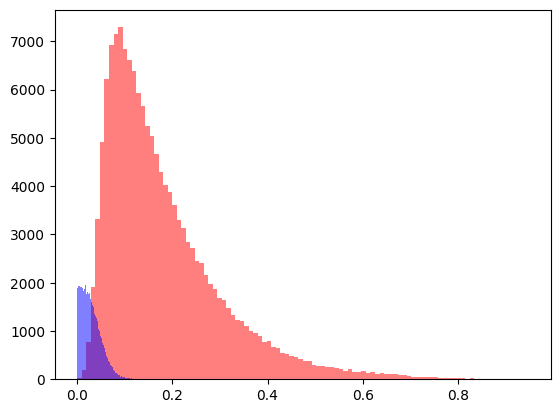

In [15]:
significant_results = [abs(result) for result in significant_results]
non_significant_results = [abs(result) for result in non_significant_results]
print(f"Significant results: {len(significant_results)}")
print(f"Non-significant results: {len(non_significant_results)}")
plt.hist(significant_results, bins=100, alpha=0.5, color='red', label='Significant Results')
plt.hist(non_significant_results, bins=100, alpha=0.5, color='blue')

Significant results: 141781
Non-significant results: 56455


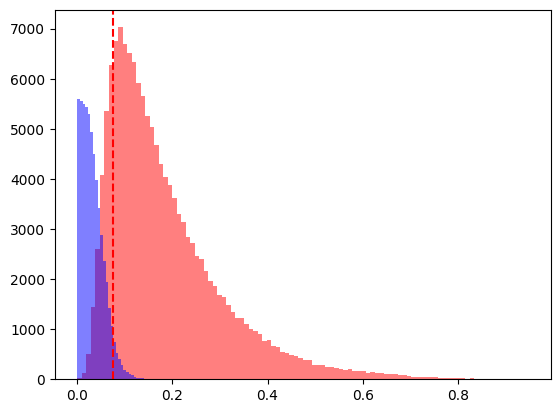

In [61]:
significant_results_corr = [abs(result) for result in signif_results_corrected]
non_significant_results = [abs(result) for result in non_signif_results_corrected]
print(f"Significant results: {len(significant_results_corr)}")
print(f"Non-significant results: {len(non_significant_results)}")
plt.hist(significant_results_corr, bins=100, alpha=0.5, color='red', label='Significant Results')
plt.hist(non_significant_results, bins=35, alpha=0.5, color='blue')
plt.axvline(x=0.0740, color='red', linestyle='--')

In [72]:
noise_threshold = np.percentile(non_significant_results, 95)
print(f"Noise threshold and threshold to be used in the algorithm: {noise_threshold}")

other_threshold = np.percentile(significant_results_corr, 14)
print(f"Other threshold: {other_threshold}")

Noise threshold and threshold to be used in the algorithm: 0.07407852631578948
Other threshold: 0.07516610526315792


In [71]:
# Count all residues with mean > threshold
num_above_threshold = sum(mean > noise_threshold for mean in significant_results_corr)
total = len(significant_results_corr)

percentage_above = num_above_threshold / total * 100

print(f"Total above threshold: {num_above_threshold} ({percentage_above:.2f}%)")

Total above threshold: 122691 (86.54%)
